# Data of PFO Array - Data Quality

### Imports

In [1]:
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_timeaxis import __get_timeaxis
from andbro__get_stream import __getStream

In [2]:
def __calculate_spectra(st, config, mode='dB'):

    from datetime import datetime
    from pandas import date_range
    from obspy import UTCDateTime
    from scipy.signal import welch
    from numpy import where, array, zeros, log10

    def __check_stream(st):
        t1 = str(st[0].stats.starttime)
        t2 = str(st[0].stats.endtime)
        for tr in st:
            if str(tr.stats.starttime) != t1 or str(tr.stats.endtime) != t2:
                print(f"ERROR: mismatch in start or endtime of trace: {tr.stats.id}")
                return

    def __make_decibel(array, relative_value):
        return 10*log10(array/relative_value)

    ## check time consistency for all traces
#     __check_stream(st)

    ## check how many intervals are possible
    if config['interval_overlap'] is None:
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/config.get('interval'))
        shift = config['interval']
    else:
        shift = int(config.get('interval')*config['interval_overlap']/100)
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/shift)



    ## pre-define psd array
    size_psd = int(config.get('nperseg')/2)+1
    psd = zeros([intervals, size_psd])

    if size_psd >= len(st[0].data):
        print(f"ERROR: reduce nperseg or noverlap or segments! {size_psd} > {len(st[0].data)}")
        return

    for i, tr in enumerate(st):

        # initite variables for while loop
        dt1 = st[0].stats.starttime
        dt2 = st[0].stats.starttime + config['interval']
        n = 0

        while dt2 <= st[0].stats.endtime:

            tr_tmp = tr.copy()
            tr_tmp.trim(starttime = UTCDateTime(dt1), endtime=UTCDateTime(dt2))

#             print(n, dt1, dt2, "\n")

#             print(config.get('nperseg'), config.get('noverlap'), len(tr_tmp.data))
            try:
                f, psd0 = welch(
                            tr_tmp.data,
                            fs=tr_tmp.stats.sampling_rate,
                            window=config.get('taper'),
                            nperseg=config.get('nperseg'),
                            noverlap=config.get('noverlap'),
                            nfft=config.get('nfft'),
                            detrend=config.get('detrend'),
                            return_onesided=config.get('onesided'),
                            scaling=config.get('scaling'),
                           )
                psd[n] = psd0
            except:
                print("failed")
                break
            
            ## adjust variables
            dt1 += shift
            dt2 += shift
            n += 1


        if config.get('frequency_limits') is not None:
            f1, f2 = config.get('frequency_limits')[0], config.get('frequency_limits')[1]
            idx1, idx2 = int(where(f <= f1)[0][0]), int(where(f >= f2)[0][0])
            ff = f[idx1:idx2]
            tmp = zeros([intervals, len(ff)])
            for j in range(intervals):
                tmp[j] = psd[j,idx1:idx2]
            psd = tmp
        else:
            ff = f


    return ff, psd

In [3]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

### Configurations

In [7]:
config = {}

config['tbeg'] = obs.UTCDateTime("2021-08-01 00:00")
config['tend'] = obs.UTCDateTime("2021-08-02 00:00")

config['seeds'] = [
                    'PY.BPH01..BHZ', 'PY.BPH01..BHN', 'PY.BPH01..BHE',
#                     'PY.BPH02..BHZ', 'PY.BPH02..BHN', 'PY.BPH02..BHE',
#                     'PY.BPH03..BHZ', 'PY.BPH03..BHN', 'PY.BPH03..BHE',
#                     'PY.BPH04..BHZ', 'PY.BPH04..BHN', 'PY.BPH04..BHE',
#                     'PY.BPH05..BHZ', 'PY.BPH05..BHN', 'PY.BPH05..BHE',
#                     'PY.BPH06..BHZ', 'PY.BPH06..BHN', 'PY.BPH06..BHE',
#                     'PY.BPH07..BHZ', 'PY.BPH07..BHN', 'PY.BPH07..BHE',
#                     'PY.BPH08..BHZ', 'PY.BPH08..BHN', 'PY.BPH08..BHE',
#                     'PY.BPH09..BHZ', 'PY.BPH09..BHN', 'PY.BPH09..BHE',
#                     'PY.BPH10..BHZ', 'PY.BPH10..BHN', 'PY.BPH10..BHE',
#                     'PY.BPH11..BHZ', 'PY.BPH11..BHN', 'PY.BPH11..BHE',
#                     'PY.BPH12..BHZ', 'PY.BPH12..BHN', 'PY.BPH12..BHE',
#                     'PY.BPH13..BHZ', 'PY.BPH13..BHN', 'PY.BPH13..BHE',

]

config['repository'] = "online"

config['outdir_figs'] = "/home/brotzer/Downloads/tmp/"

config['channels'] = np.unique(np.array([i.split(".")[3] for i in config['seeds']]))
config['stations'] = np.unique(np.array([i.split(".")[1] for i in config['seeds']]))


import seaborn as sns
colors = list(sns.color_palette("husl", 10))
config['colors'] = dict(zip(config['stations'], colors))

## Load Data

In [8]:
st = __getStream(config)

# st.resample(20)
# st.plot(equal_scale=False);

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...


In [9]:
st

3 Trace(s) in Stream:
PY.BPH01..BHZ | 2021-07-31T23:59:59.996900Z - 2021-08-01T23:59:59.996900Z | 40.0 Hz, 3456001 samples
PY.BPH01..BHN | 2021-07-31T23:59:59.996900Z - 2021-08-01T23:59:59.996900Z | 40.0 Hz, 3456001 samples
PY.BPH01..BHE | 2021-07-31T23:59:59.996900Z - 2021-08-01T23:59:59.996900Z | 40.0 Hz, 3456001 samples

## Plotting

In [ ]:
fig, ax = plt.subplots(len(set(config['stations'])),3, figsize=(15,10), sharex=True)

for k, component in enumerate(['Z','N','E']):
    for i, tr in enumerate(st.select(channel=f"*{component}")):
        if np.isnan(tr.data).all():
            ax[i,k].fill_between(tr.times(), -1, 1, color='red', alpha=0.3, label=f'{tr.stats.station}')
        else:
            ax[i,k].plot(tr.times(),tr.data*1e6, color='k', label=f'{tr.stats.station}');
        ax[i,k].legend(loc="upper right")
        
    ax[0,k].set_title(tr.stats.channel)
    
fig.show();

In [ ]:
config['interval'] = 3600
config['interval_overlap'] = 50 # in percent
config['taper'] = 'hanning'
config['segments'] = 1e2
config['nperseg'] = 256*config.get('segments')
config['noverlap'] = 64*config.get('segments')
config['nfft'] = None
config['detrend'] = 'constant'
config['scaling'] = 'density'
config['onesided'] = True
config['frequency_limits'] = (0, 10) # in Hz



psds, frequencies, station_names = [], [], []

for cha in config['channels']:
    for sta in config['stations']:
#         print(st.select(id=f"*.{sta}.*.{cha}"))
        station_names.append(f"{sta}.{cha}")
        
        ff, psd = __calculate_spectra(st.select(id=f"*.{sta}.*.{cha}"), config, mode=None)

        psd_median = __get_median_psd(psd)
        
        psds.append(psd_median)
        frequencies.append(ff)

In [ ]:
def __makeplot_PSD_components(psds, frequencies, config):

    tmp = np.load(f"/import/kilauea-data/LNM/data/MODELS/"+"noise_models.npz")
    nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

    nlnm_psd = 10**(nlnm/10)
    nhnm_psd = 10**(nhnm/10)

    fig, ax = plt.subplots(3,1,figsize=(15,15), sharex=True)

    for psd, ff, station_name in zip(psds, frequencies, station_names):
        
        pp = np.zeros(len(ff))
        pp[:-1] = 1/ff[1:]        
        
        if np.nonzero(psd)[0].size == 0:
            continue

        if station_name[-1] == "Z":
            ax[0].loglog(pp, psd, label=station_name, color=config['colors'][station_name.split('.')[0]])
        elif station_name[-1] in ["N","1"]:
            ax[1].loglog(pp, psd, label=station_name, color=config['colors'][station_name.split('.')[0]])
        elif station_name[-1] in ["E","2"]:
            ax[2].loglog(pp, psd, label=station_name, color=config['colors'][station_name.split('.')[0]])

    for jj in range(3):
        ax[jj].loglog(nm_periods, nlnm_psd, ls="--", color="black")
        ax[jj].loglog(nm_periods, nhnm_psd, ls="--", color="black")

        ax[jj].legend(loc="upper right")

        ax[jj].set_ylabel(r"PSD ($m^2 / s^4 / Hz$)", fontsize=14)

        ax[jj].set_xlim(1,200)
        ax[jj].set_ylim(1e-19, 1e-9)

    ax[jj].set_xlabel("Period (s)", fontsize=14)
    plt.show();
    return fig

    
fig = __makeplot_PSD_components(psds, frequencies, config)

### Processing

In [ ]:
st2 = st.copy();

st2.detrend('simple');

# for tr in st:
#     if tr.stats.sampling_rate > 20:
#         tr.resample(20);

st2.taper(0.1)

config['filter'] = {'type':'bandpass', 
                    'fmin':0.01, 
                    'fmax':1}

if config['filter']:
    st2.filter(config['filter']['type'], 
              freqmin=config['filter']['fmin'],
              freqmax=config['filter']['fmax'], 
              corners=4, 
              zerophase=True);
print(st2);

In [ ]:
fig, ax = plt.subplots(len(stations),3, figsize=(15,10), sharex=True)

for k, component in enumerate(['Z','N','E']):
    for i, tr in enumerate(st2.select(channel=f"*{component}")):
        
        if np.isnan(tr.data).all():
            ax[i,k].fill_between(tr.times(), -1, 1, color='red', alpha=0.3, label=f'{tr.stats.station}')
        else:
            ax[i,k].plot(tr.times(),tr.data*1e6, color='k', label=f'{tr.stats.station}');
        ax[i,k].legend(loc="upper right")
        
    ax[0,k].set_title(tr.stats.channel)
    
    
fig.show();

## LOOP

In [5]:
config['interval'] = 3600
config['interval_overlap'] = 50 # in percent
config['taper'] = 'hanning'
config['segments'] = 1e2
config['nperseg'] = 256*config.get('segments')
config['noverlap'] = 64*config.get('segments')
config['nfft'] = None
config['detrend'] = 'constant'
config['scaling'] = 'density'
config['onesided'] = True
config['frequency_limits'] = (0, 10) # in Hz


In [6]:
def __makeplot_PSD_components(psds, frequencies, config):

    tmp = np.load(f"/import/kilauea-data/LNM/data/MODELS/"+"noise_models.npz")
    nm_periods, nlnm, nhnm = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

    nlnm_psd = 10**(nlnm/10)
    nhnm_psd = 10**(nhnm/10)

    fig, ax = plt.subplots(3,1,figsize=(15,15), sharex=True)

    for psd, ff, station_name in zip(psds, frequencies, station_names):
        
        pp = np.zeros(len(ff))
        pp[:-1] = 1/ff[1:]        
        
        if np.nonzero(psd)[0].size == 0:
            continue

        if station_name[-1] == "Z":
            ax[0].loglog(pp, psd, label=station_name)
        elif station_name[-1] == "N":
            ax[1].loglog(pp, psd, label=station_name)
        elif station_name[-1] == "E":
            ax[2].loglog(pp, psd, label=station_name)

    for jj in range(3):
        ax[jj].loglog(nm_periods, nlnm_psd, ls="--", color="black")
        ax[jj].loglog(nm_periods, nhnm_psd, ls="--", color="black")

        ax[jj].legend(loc="upper right")

        ax[jj].set_ylabel(r"PSD ($m^2 / s^4 / Hz$)", fontsize=14)

        ax[jj].set_xlim(1,200)
        ax[jj].set_ylim(1e-19, 1e-9)

    ax[jj].set_xlabel("Period (s)", fontsize=14)

    ax[0].set_title(f"Vertical Component ({station_name.split('.')[1]})")
    ax[1].set_title(f"North Component ({station_name.split('.')[1]})")
    ax[2].set_title(f"East Component ({station_name.split('.')[1]})")

    ax[jj]
    
    plt.show();
    return fig

### Loop over all PFO array stations

In [ ]:
for i in np.arange(1,14):

    i = str(i).rjust(2,"0")
    
    config['seeds'] = [f'PY.BPH{i}..BHZ', f'PY.BPH{i}..BHN', f'PY.BPH{i}..BHE']
    
    config['stations'] = np.unique(np.array([j.split(".")[1] for j in config['seeds']]))
    config['channels'] = np.unique(np.array([j.split(".")[3] for j in config['seeds']]))
    
    st = __getStream(config)

    psds, frequencies, station_names = [], [], []

    for cha in config['channels']:
        for sta in config['stations']:
            
            print(st.select(id=f"*.{sta}.*.{cha}"))
            
            station_names.append(f"{sta}.{cha}")

            ff, psd = __calculate_spectra(st.select(id=f"*.{sta}.*.{cha}"), config, mode=None)

            psd_median = __get_median_psd(psd)

            psds.append(psd_median)
            frequencies.append(ff)
            
    fig = __makeplot_PSD_components(psds, frequencies, config)
    fig.savefig(config['outdir_figs']+sta+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)
    
    del st

### Loop over one station but several dates 

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-01T00:00:00.000000Z - 2019-08-01T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-01T00:00:00.000000Z - 2019-08-01T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-01T00:00:00.000000Z - 2019-08-01T23:59:59.950000Z | 20.0 Hz, 1728000 samples


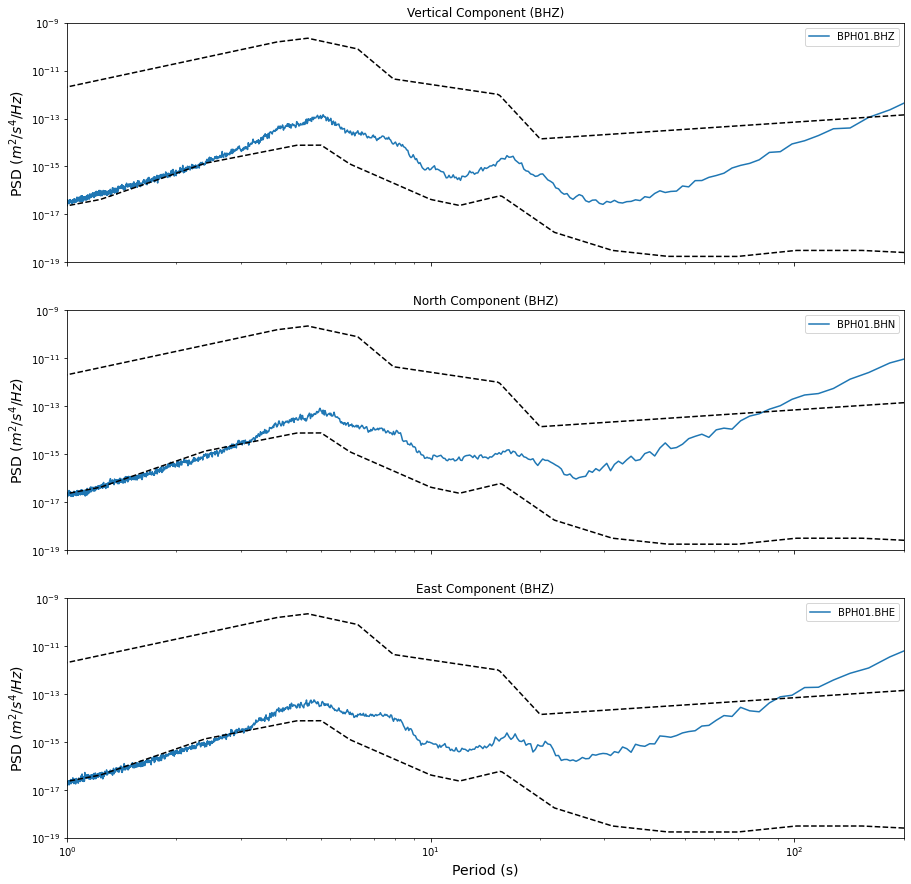

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-02T00:00:00.000000Z - 2019-08-02T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-02T00:00:00.000000Z - 2019-08-02T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-02T00:00:00.000000Z - 2019-08-02T23:59:59.950000Z | 20.0 Hz, 1728000 samples


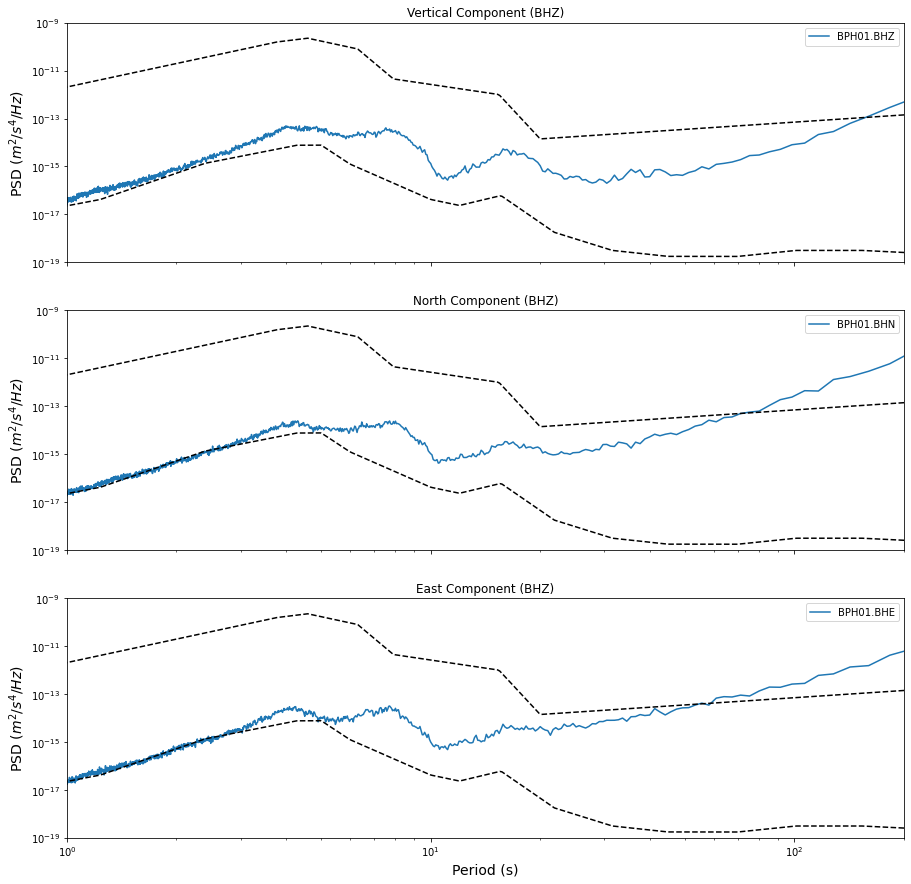

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-03T00:00:00.000000Z - 2019-08-03T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-03T00:00:00.000000Z - 2019-08-03T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-03T00:00:00.000000Z - 2019-08-03T23:59:59.950000Z | 20.0 Hz, 1728000 samples


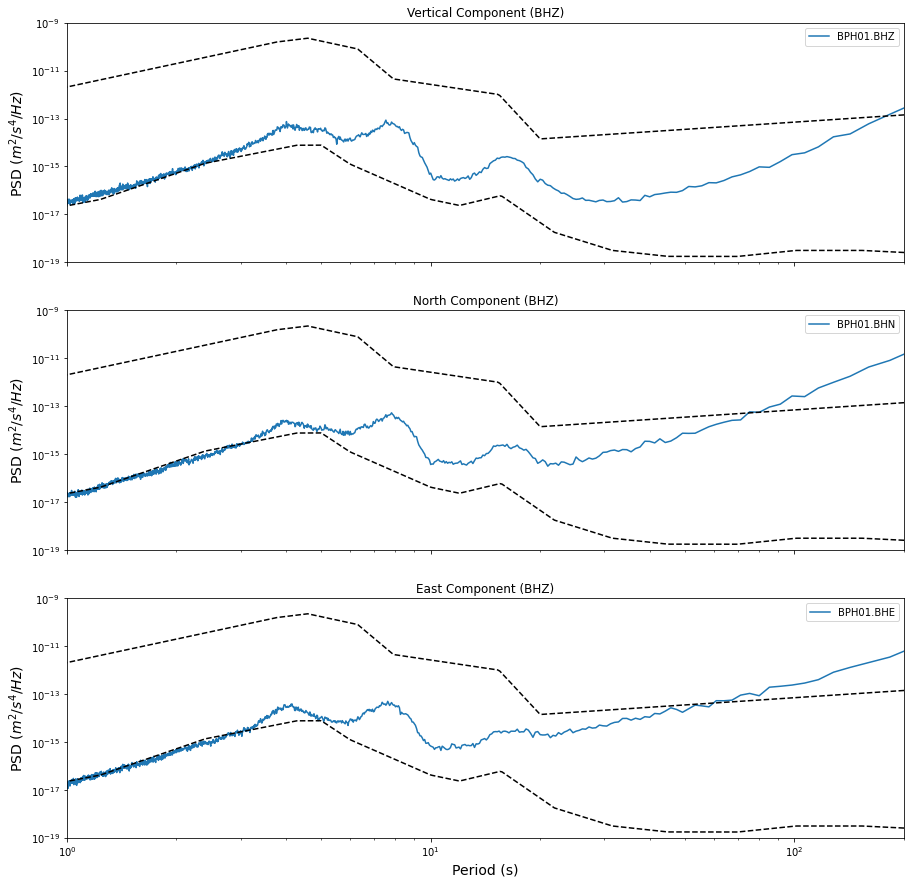

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-04T00:00:00.000000Z - 2019-08-04T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-04T00:00:00.000000Z - 2019-08-04T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-04T00:00:00.000000Z - 2019-08-04T23:59:59.950000Z | 20.0 Hz, 1728000 samples


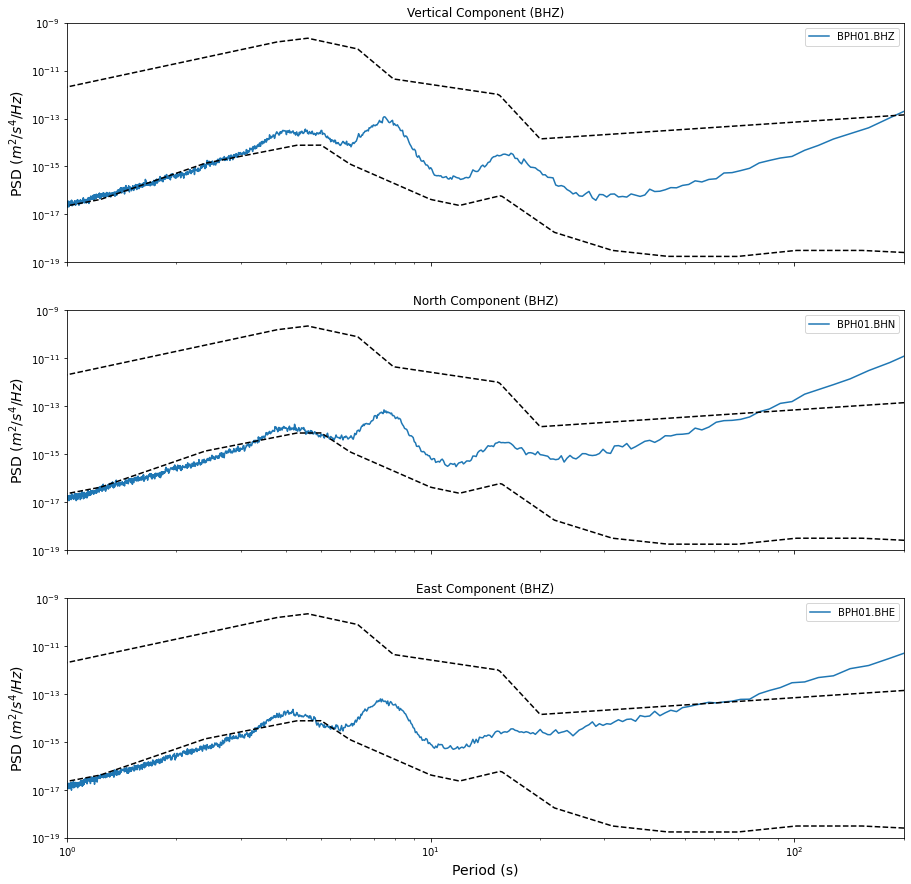

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-05T00:00:00.000000Z - 2019-08-05T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-05T00:00:00.000000Z - 2019-08-05T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-05T00:00:00.000000Z - 2019-08-05T23:59:59.950000Z | 20.0 Hz, 1728000 samples


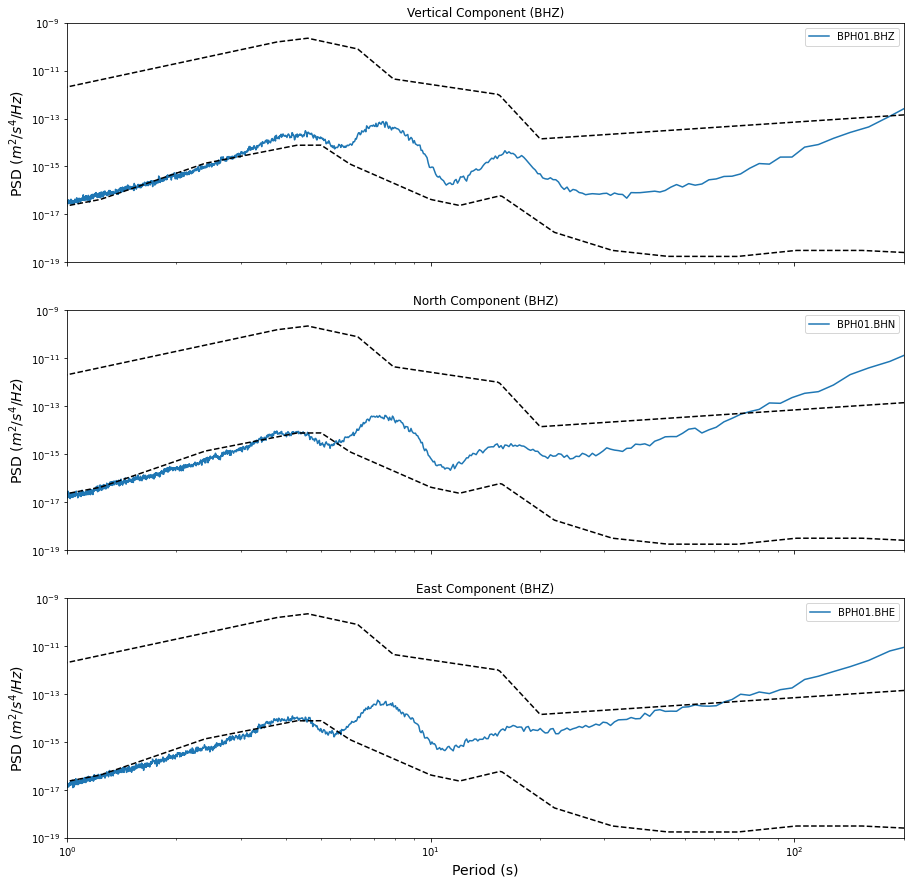

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-06T00:00:00.000000Z - 2019-08-06T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-06T00:00:00.000000Z - 2019-08-06T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-06T00:00:00.000000Z - 2019-08-06T23:59:59.950000Z | 20.0 Hz, 1728000 samples


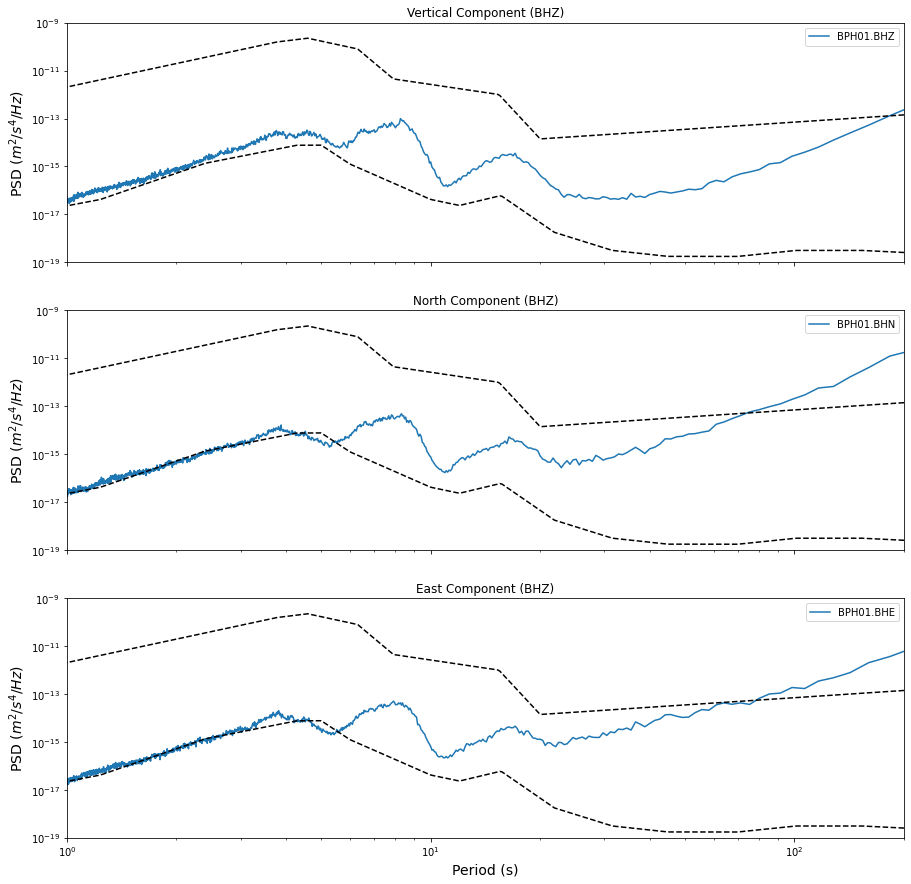

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-07T00:00:00.000000Z - 2019-08-07T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-07T00:00:00.000000Z - 2019-08-07T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-07T00:00:00.000000Z - 2019-08-07T23:59:59.950000Z | 20.0 Hz, 1728000 samples


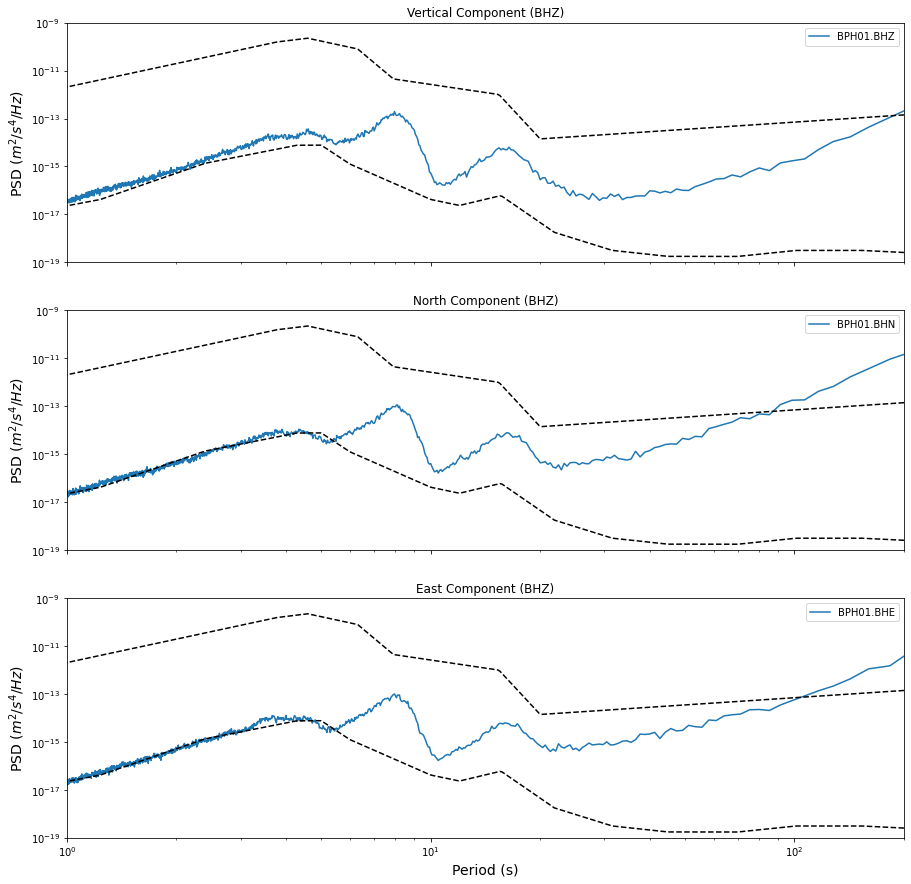

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-08T00:00:00.000000Z - 2019-08-08T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-08T00:00:00.000000Z - 2019-08-08T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-08T00:00:00.000000Z - 2019-08-08T23:59:59.950000Z | 20.0 Hz, 1728000 samples


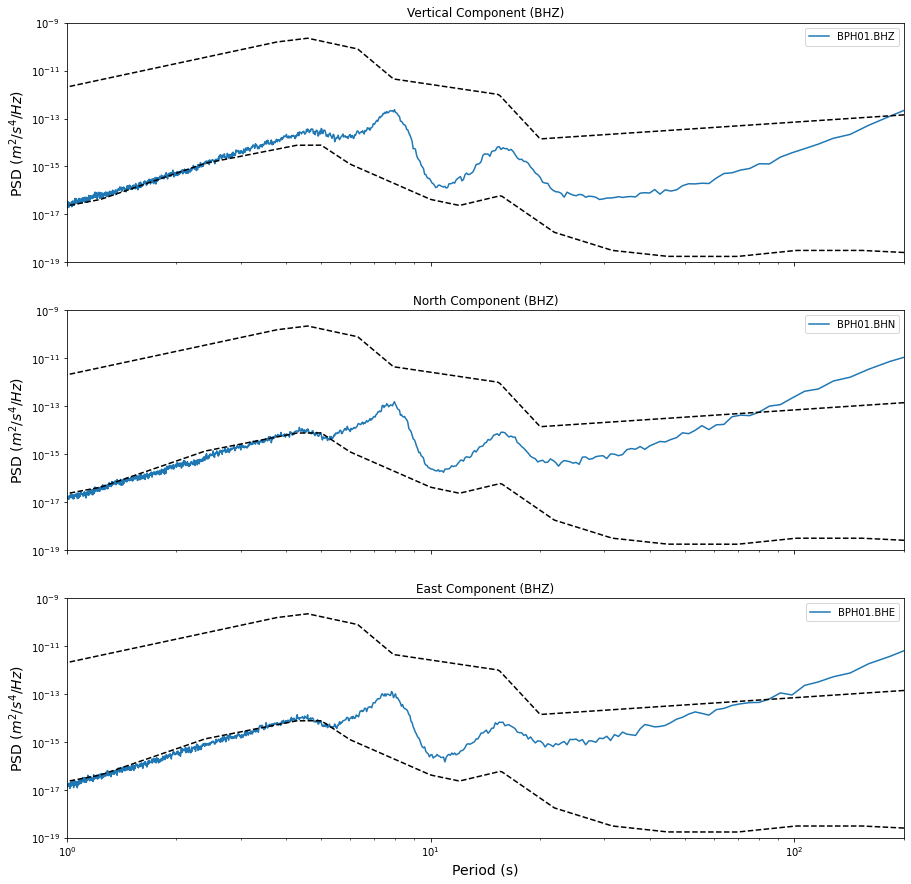

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-09T00:00:00.000000Z - 2019-08-09T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-09T00:00:00.000000Z - 2019-08-09T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-09T00:00:00.000000Z - 2019-08-09T23:59:59.950000Z | 20.0 Hz, 1728000 samples


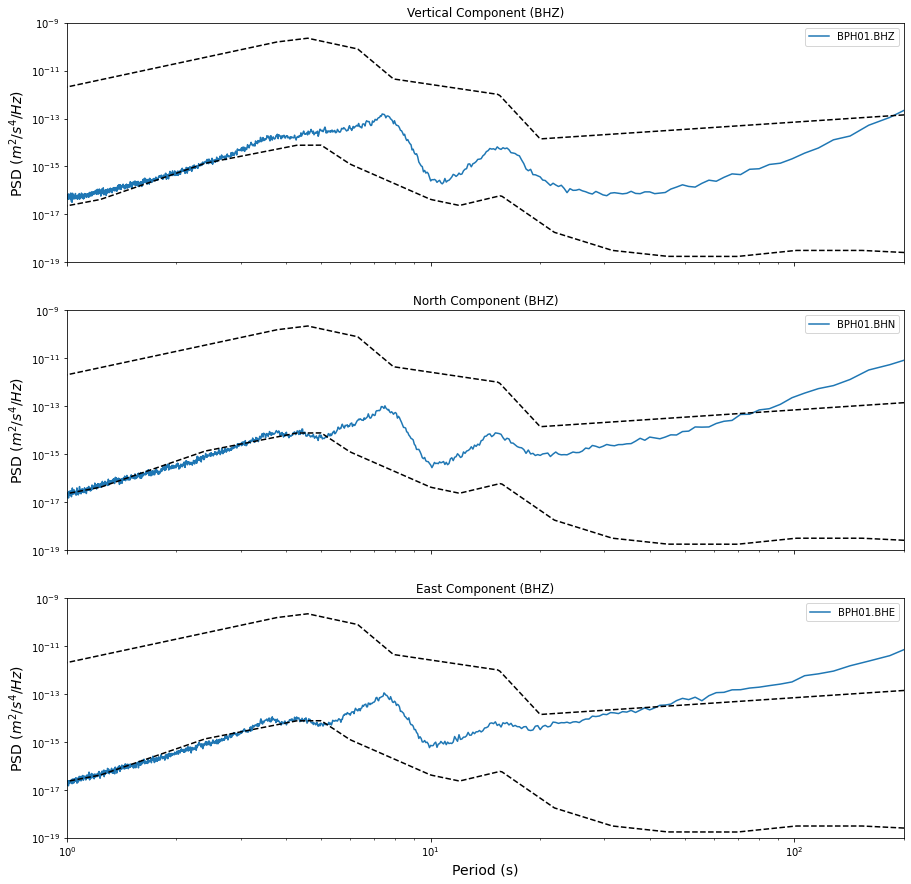

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-10T00:00:00.000000Z - 2019-08-10T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-10T00:00:00.000000Z - 2019-08-10T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-10T00:00:00.000000Z - 2019-08-10T23:59:59.950000Z | 20.0 Hz, 1728000 samples


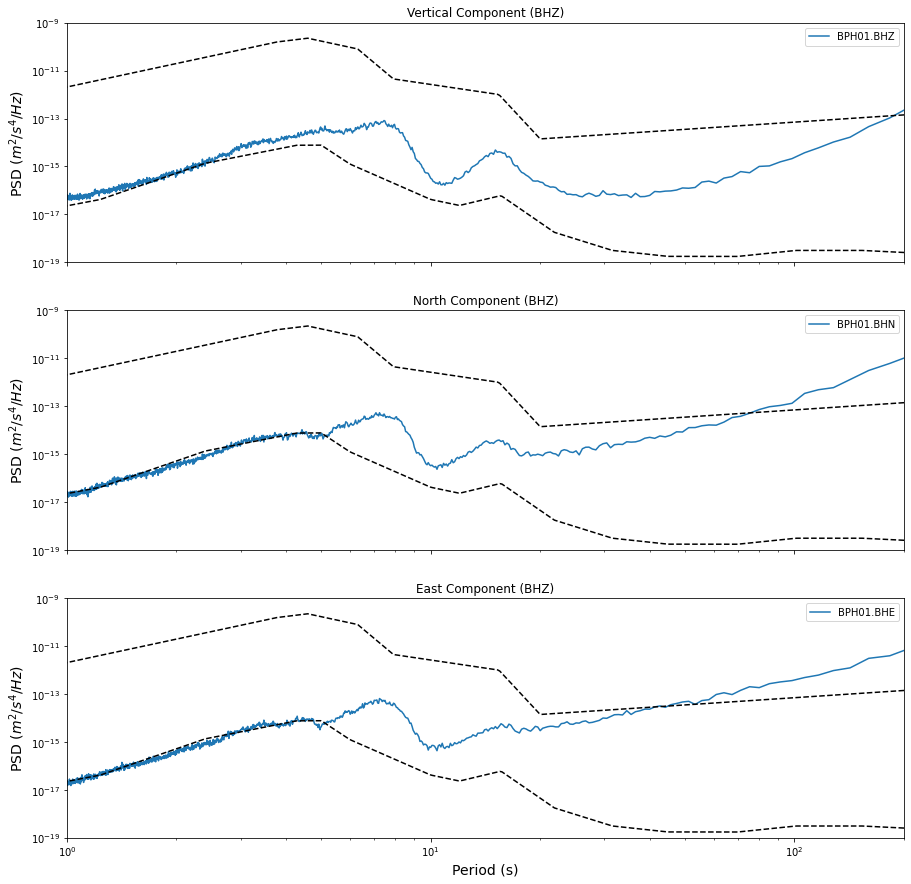

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-11T00:00:00.000000Z - 2019-08-11T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-11T00:00:00.000000Z - 2019-08-11T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-11T00:00:00.000000Z - 2019-08-11T23:59:59.950000Z | 20.0 Hz, 1728000 samples


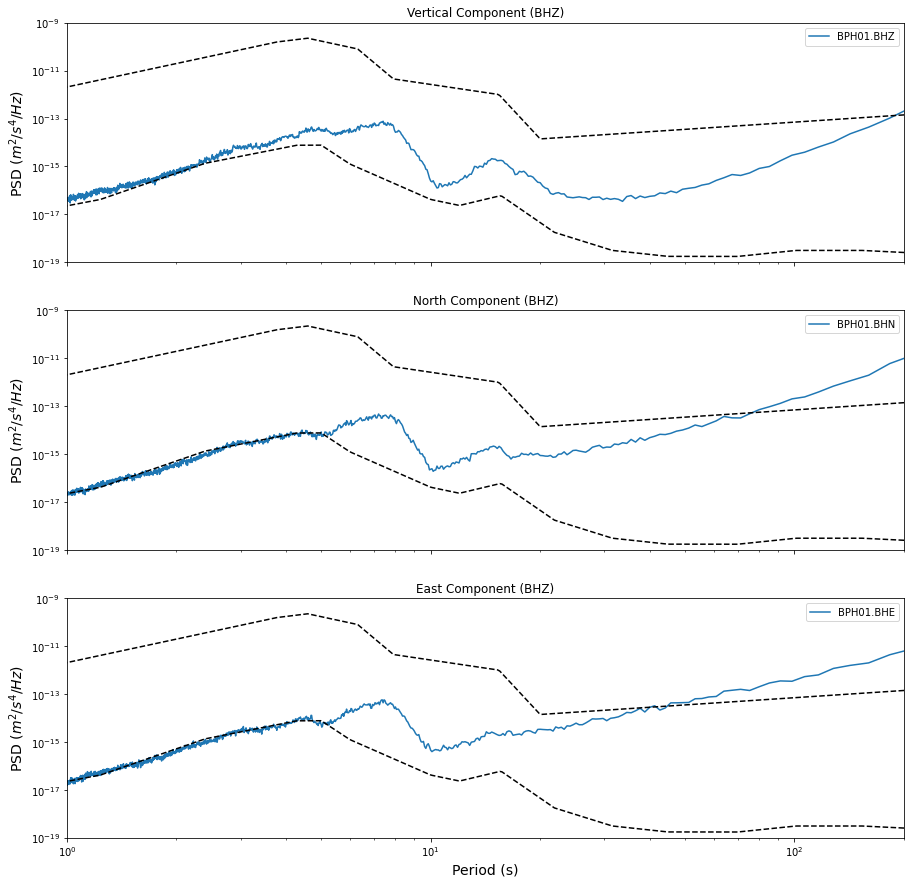

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-12T00:00:00.000000Z - 2019-08-12T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-12T00:00:00.000000Z - 2019-08-12T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-12T00:00:00.000000Z - 2019-08-12T23:59:59.950000Z | 20.0 Hz, 1728000 samples


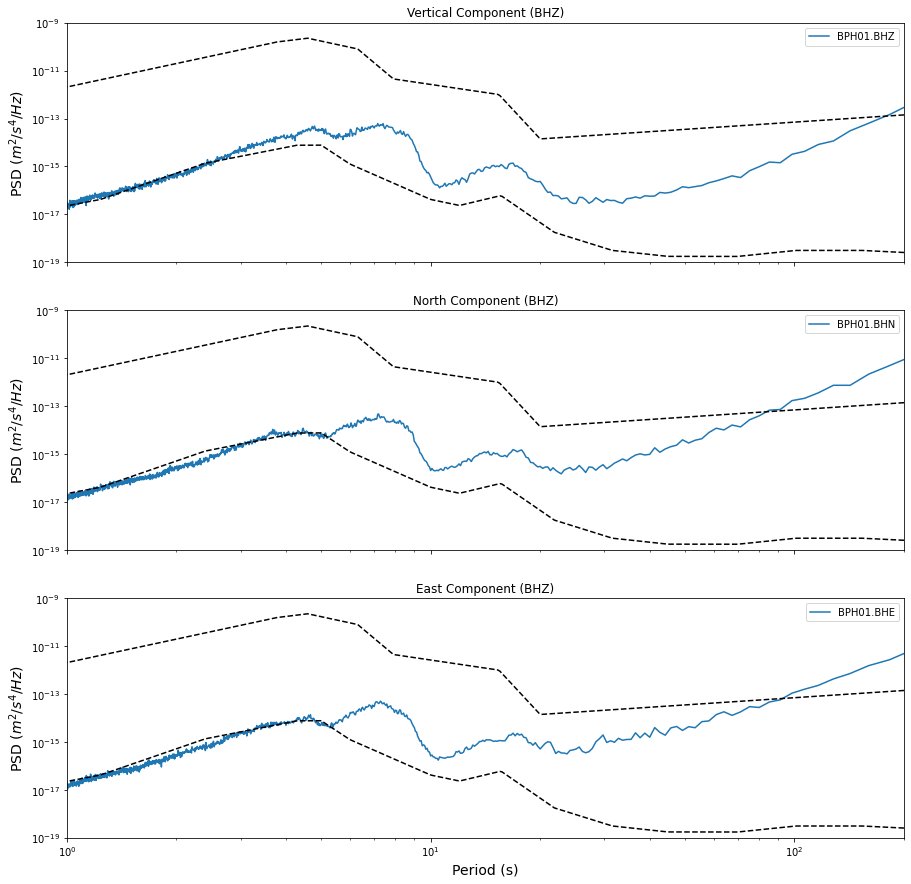

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-13T00:00:00.000000Z - 2019-08-13T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-13T00:00:00.000000Z - 2019-08-13T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-13T00:00:00.000000Z - 2019-08-13T23:59:59.950000Z | 20.0 Hz, 1728000 samples


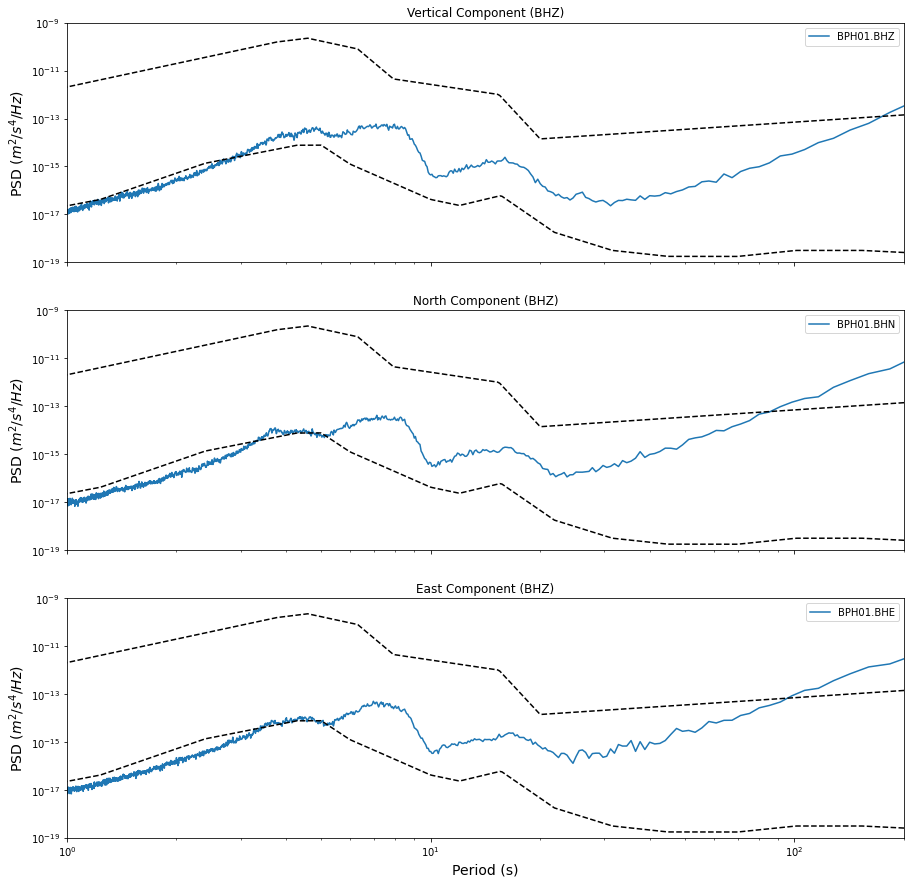

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-14T00:00:00.000000Z - 2019-08-14T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-14T00:00:00.000000Z - 2019-08-14T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-14T00:00:00.000000Z - 2019-08-14T23:59:59.950000Z | 20.0 Hz, 1728000 samples


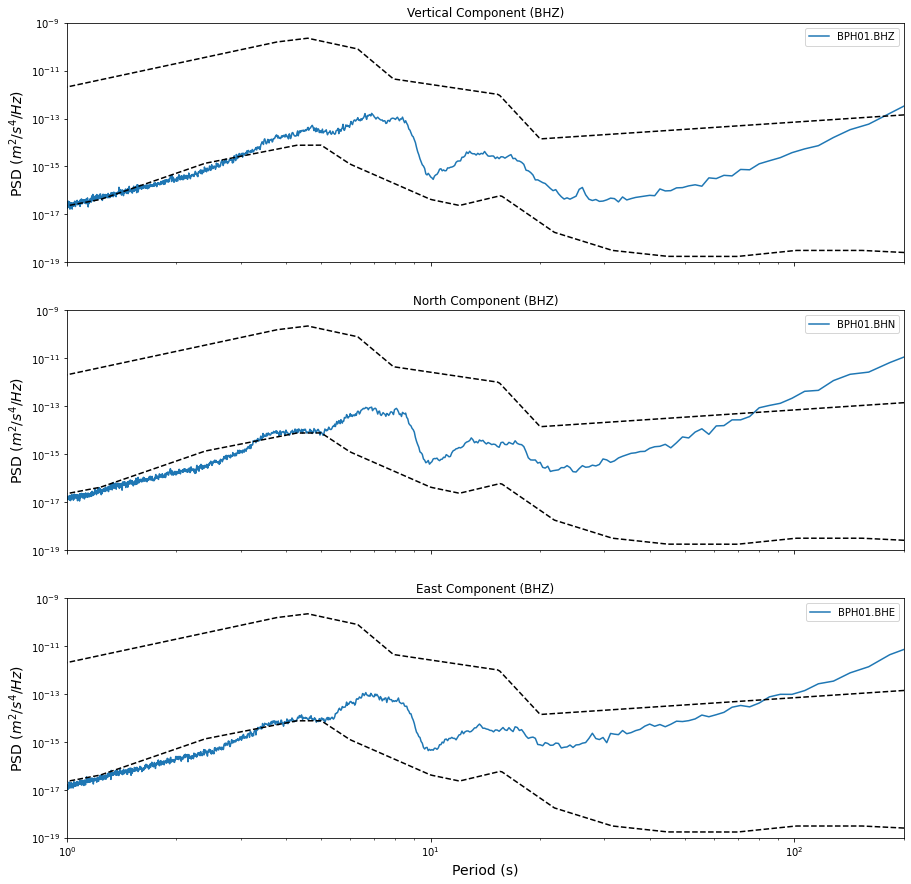

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-15T00:00:00.000000Z - 2019-08-15T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-15T00:00:00.000000Z - 2019-08-15T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-15T00:00:00.000000Z - 2019-08-15T23:59:59.950000Z | 20.0 Hz, 1728000 samples


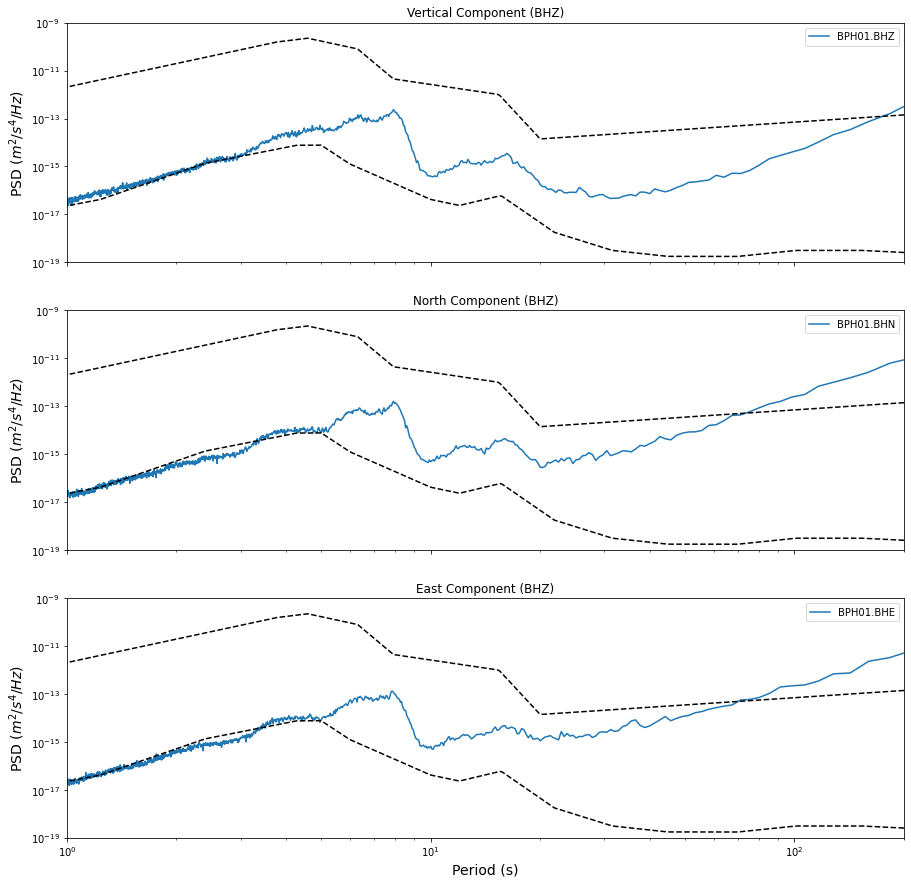

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-16T00:00:00.000000Z - 2019-08-16T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-16T00:00:00.000000Z - 2019-08-16T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-16T00:00:00.000000Z - 2019-08-16T23:59:59.950000Z | 20.0 Hz, 1728000 samples


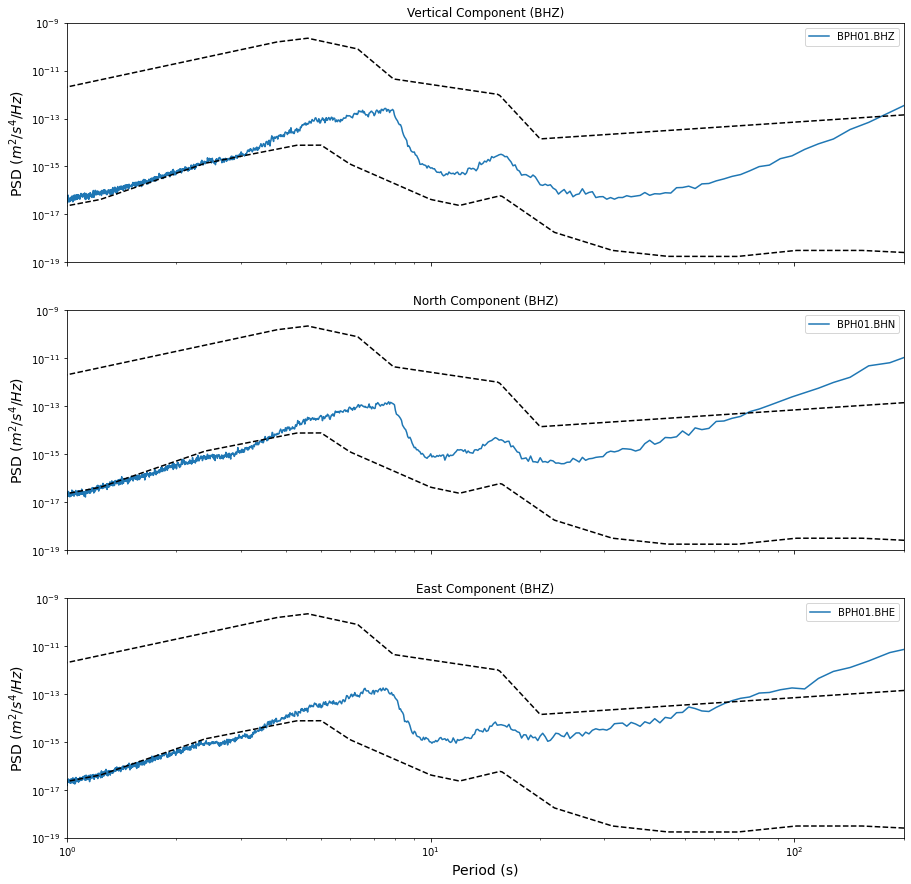

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-17T00:00:00.000000Z - 2019-08-17T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-17T00:00:00.000000Z - 2019-08-17T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-17T00:00:00.000000Z - 2019-08-17T23:59:59.950000Z | 20.0 Hz, 1728000 samples


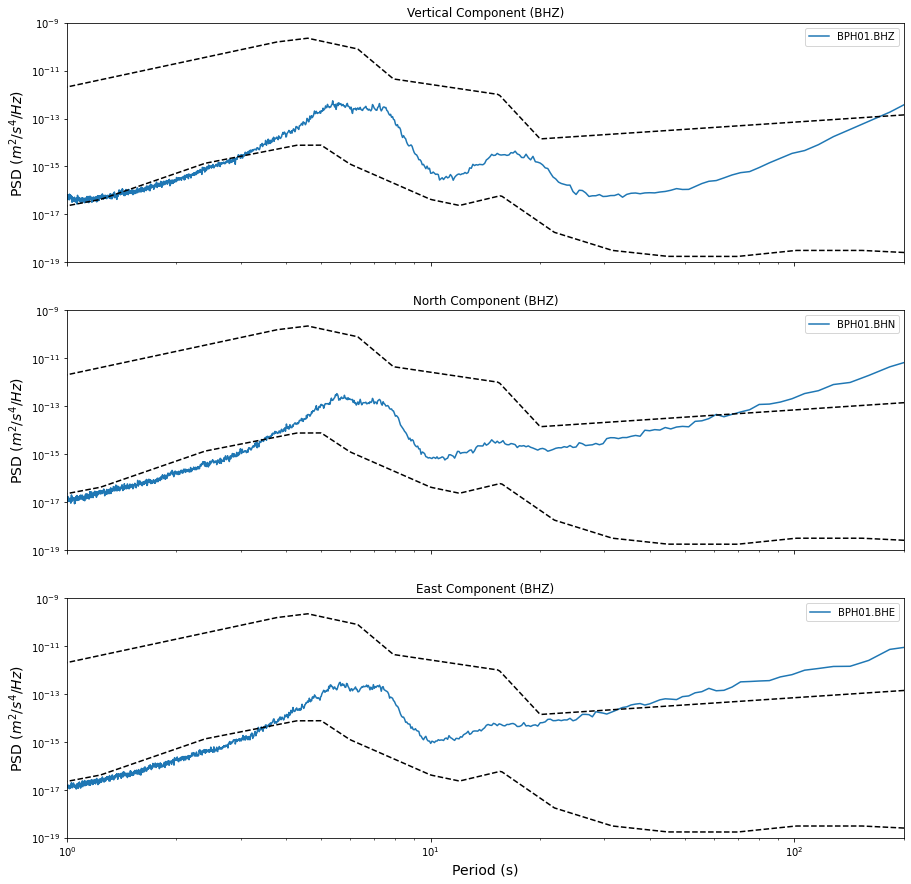

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-18T00:00:00.000000Z - 2019-08-18T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-18T00:00:00.000000Z - 2019-08-18T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-18T00:00:00.000000Z - 2019-08-18T23:59:59.950000Z | 20.0 Hz, 1728000 samples


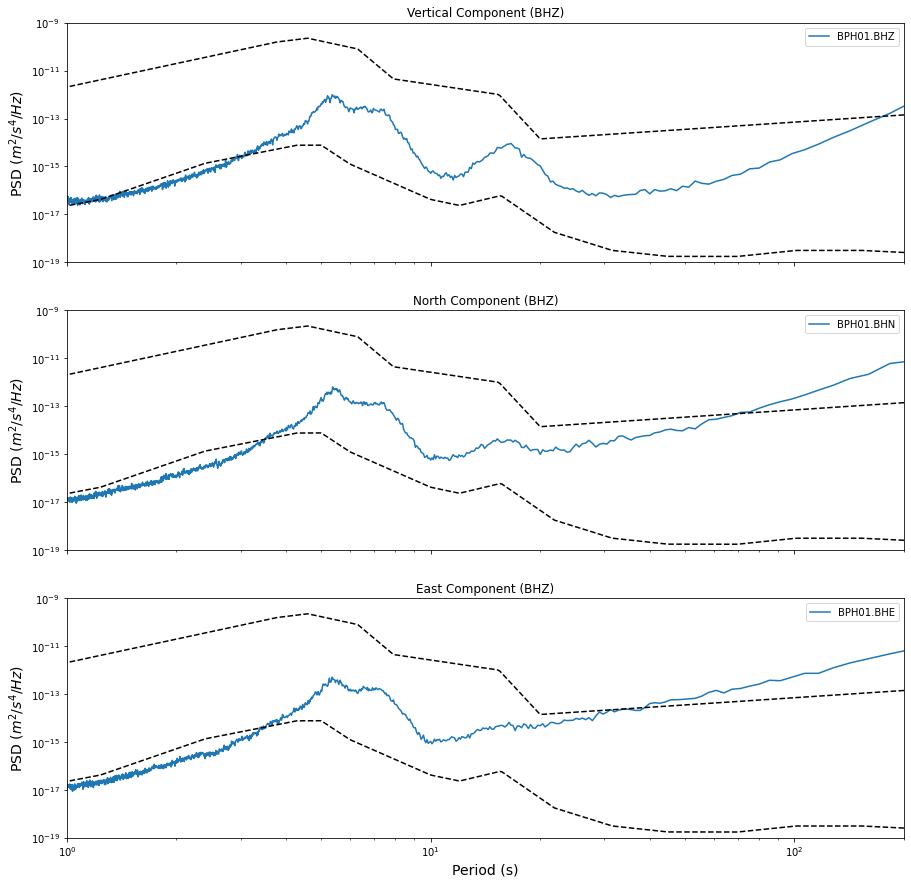

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-19T00:00:00.000000Z - 2019-08-19T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-19T00:00:00.000000Z - 2019-08-19T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-19T00:00:00.000000Z - 2019-08-19T23:59:59.950000Z | 20.0 Hz, 1728000 samples


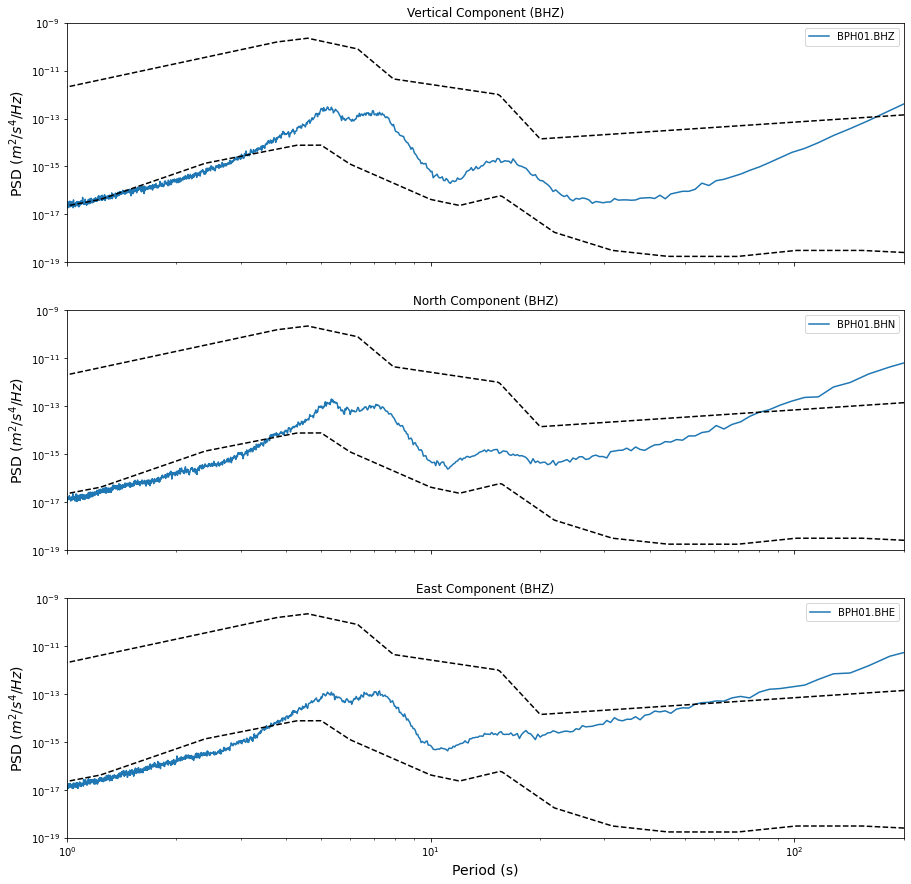

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-20T00:00:00.000000Z - 2019-08-20T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-20T00:00:00.000000Z - 2019-08-20T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-20T00:00:00.000000Z - 2019-08-20T23:59:59.950000Z | 20.0 Hz, 1728000 samples


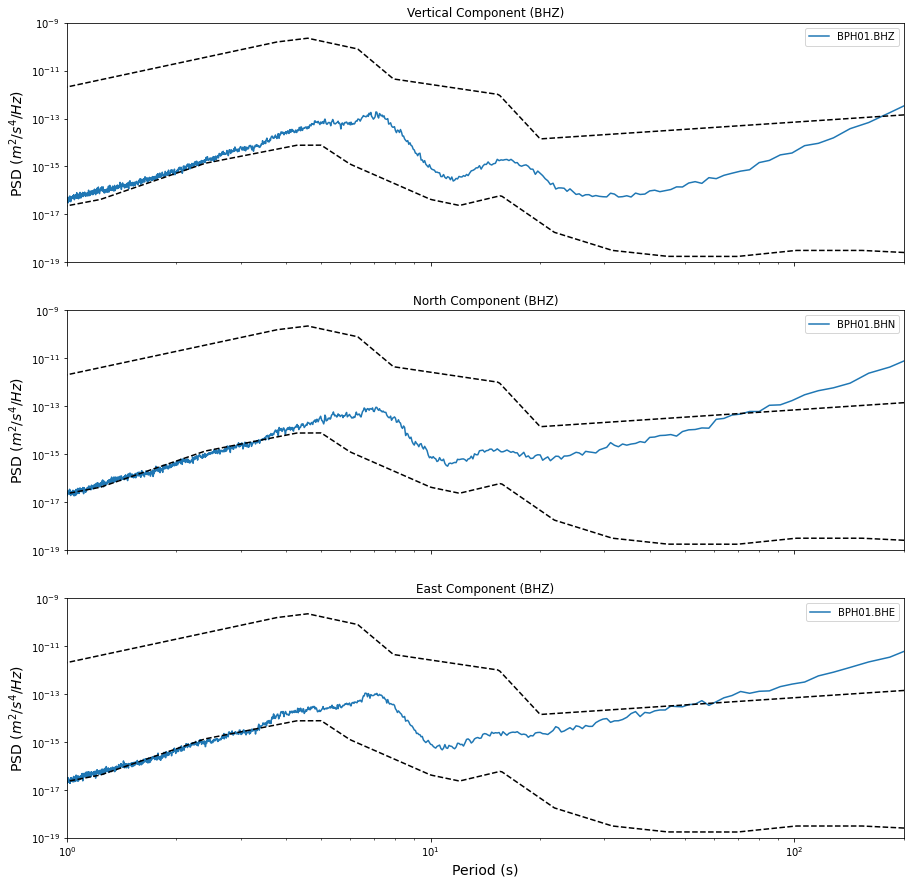

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-21T00:00:00.000000Z - 2019-08-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-21T00:00:00.000000Z - 2019-08-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-21T00:00:00.000000Z - 2019-08-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples


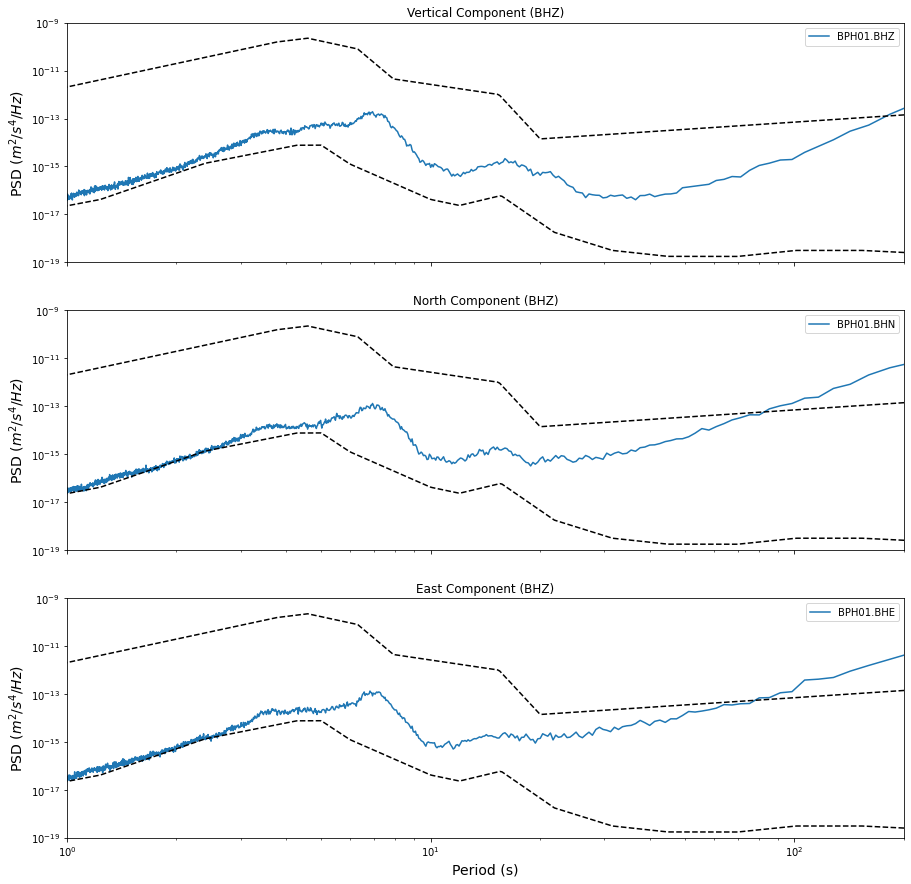

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-22T00:00:00.000000Z - 2019-08-22T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-22T00:00:00.000000Z - 2019-08-22T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-22T00:00:00.000000Z - 2019-08-22T23:59:59.950000Z | 20.0 Hz, 1728000 samples


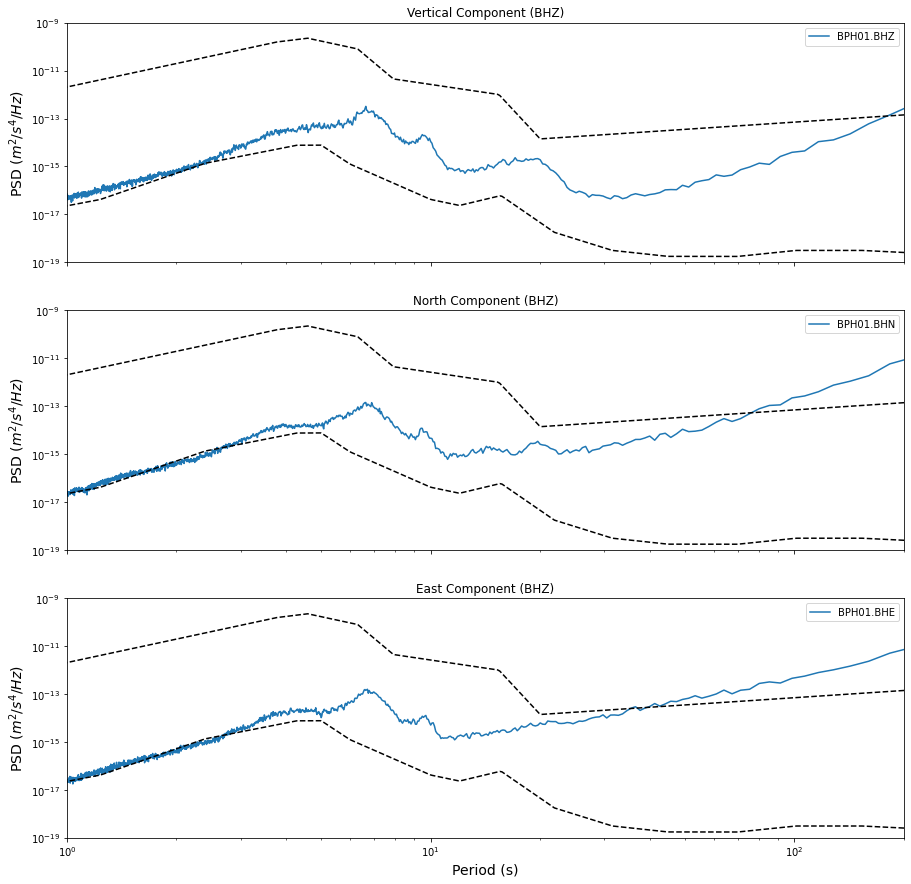

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-23T00:00:00.000000Z - 2019-08-23T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-23T00:00:00.000000Z - 2019-08-23T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-23T00:00:00.000000Z - 2019-08-23T23:59:59.950000Z | 20.0 Hz, 1728000 samples


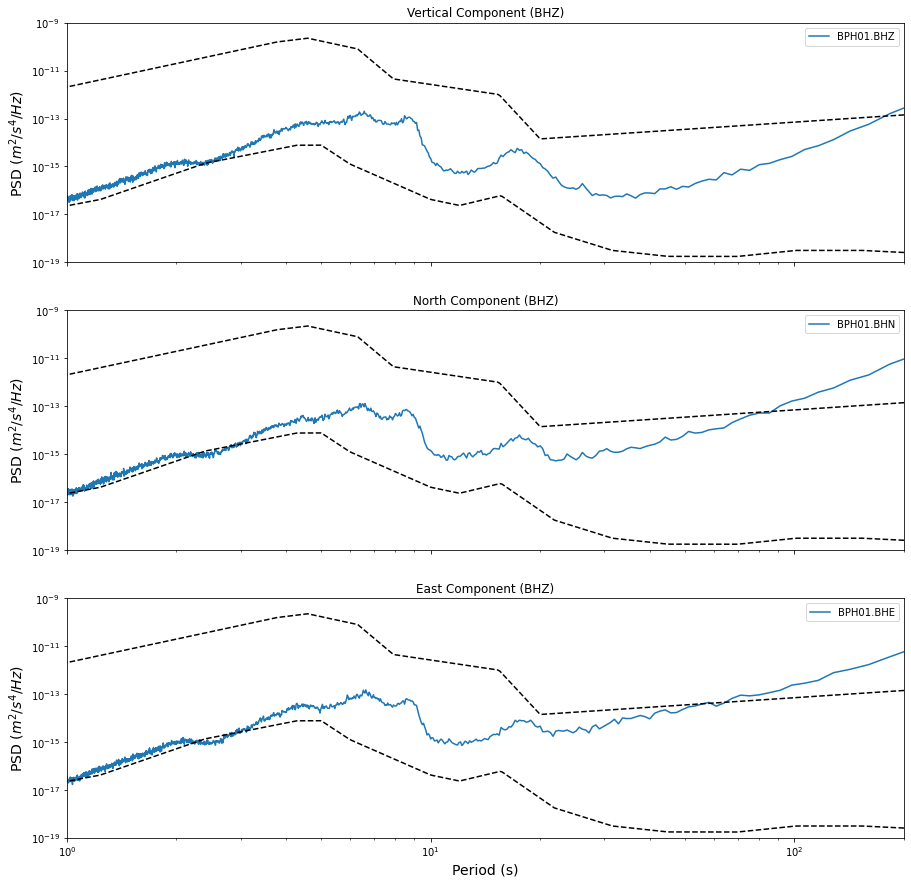

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-24T00:00:00.000000Z - 2019-08-24T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-24T00:00:00.000000Z - 2019-08-24T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-24T00:00:00.000000Z - 2019-08-24T23:59:59.950000Z | 20.0 Hz, 1728000 samples


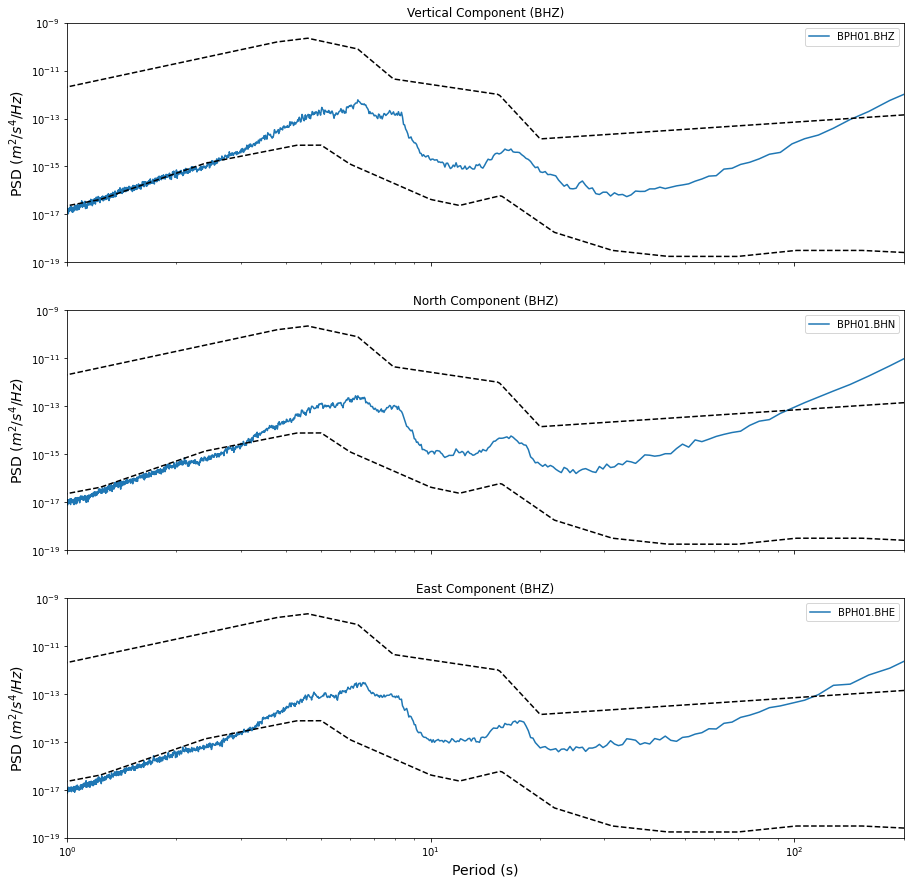

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-25T00:00:00.000000Z - 2019-08-25T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-25T00:00:00.000000Z - 2019-08-25T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-25T00:00:00.000000Z - 2019-08-25T23:59:59.950000Z | 20.0 Hz, 1728000 samples


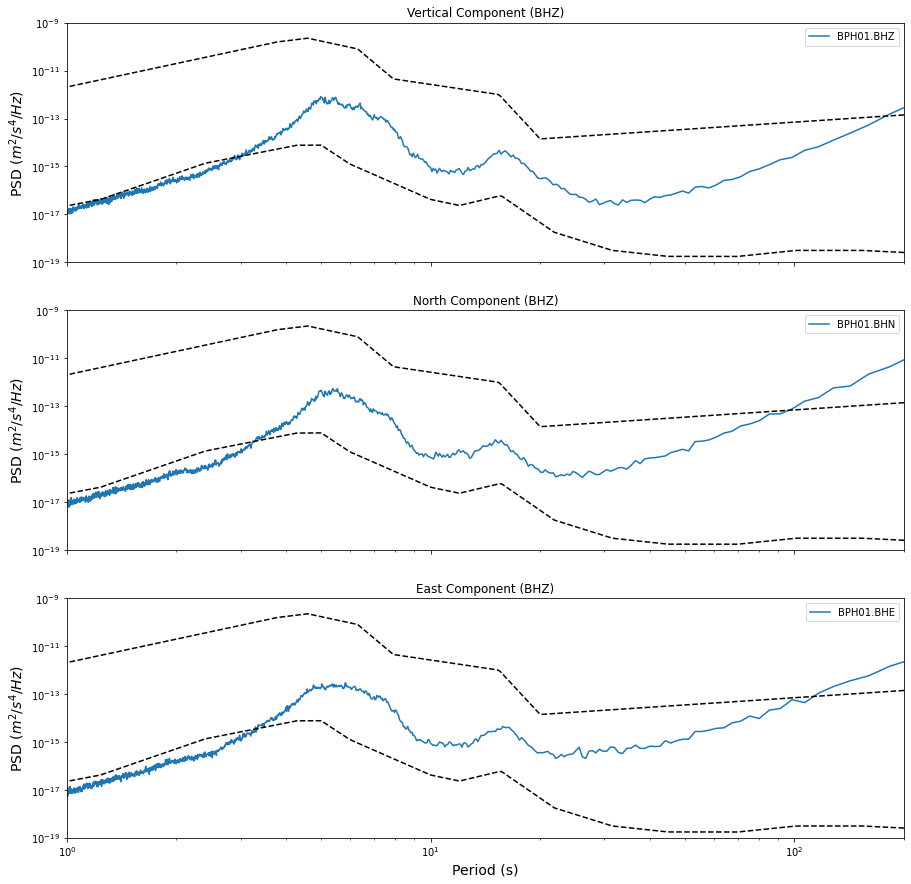

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-26T00:00:00.000000Z - 2019-08-26T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-26T00:00:00.000000Z - 2019-08-26T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-26T00:00:00.000000Z - 2019-08-26T23:59:59.950000Z | 20.0 Hz, 1728000 samples


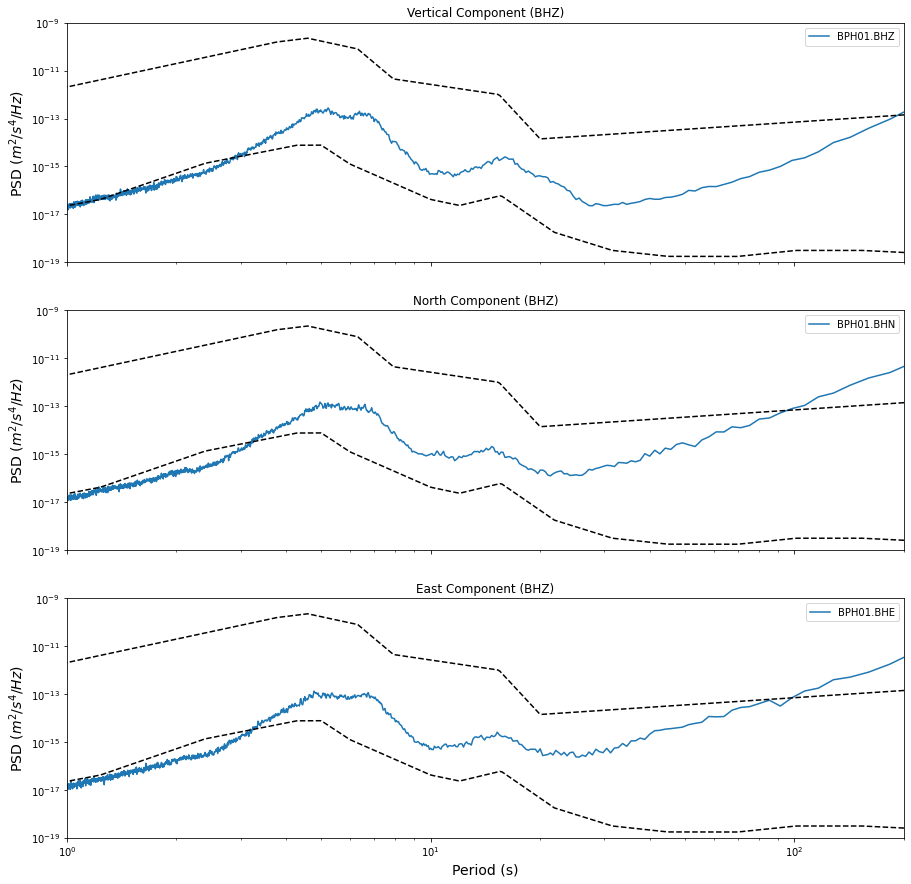

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-27T00:00:00.000000Z - 2019-08-27T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-27T00:00:00.000000Z - 2019-08-27T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-27T00:00:00.000000Z - 2019-08-27T23:59:59.950000Z | 20.0 Hz, 1728000 samples


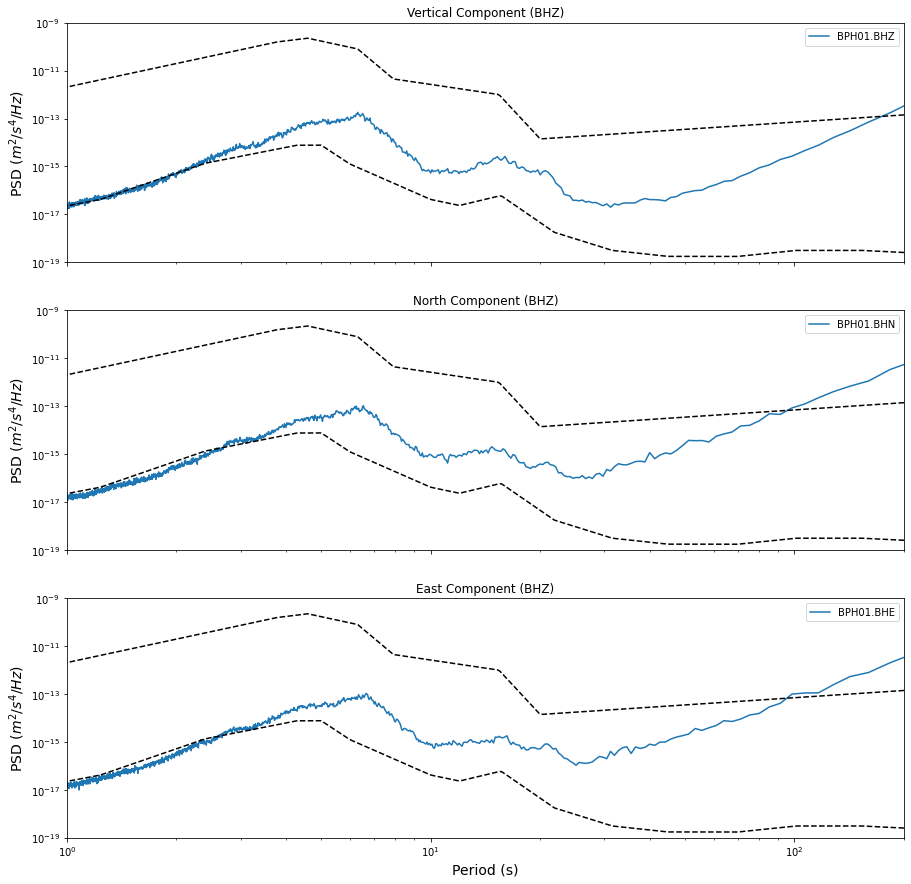

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-28T00:00:00.000000Z - 2019-08-28T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-28T00:00:00.000000Z - 2019-08-28T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-28T00:00:00.000000Z - 2019-08-28T23:59:59.950000Z | 20.0 Hz, 1728000 samples


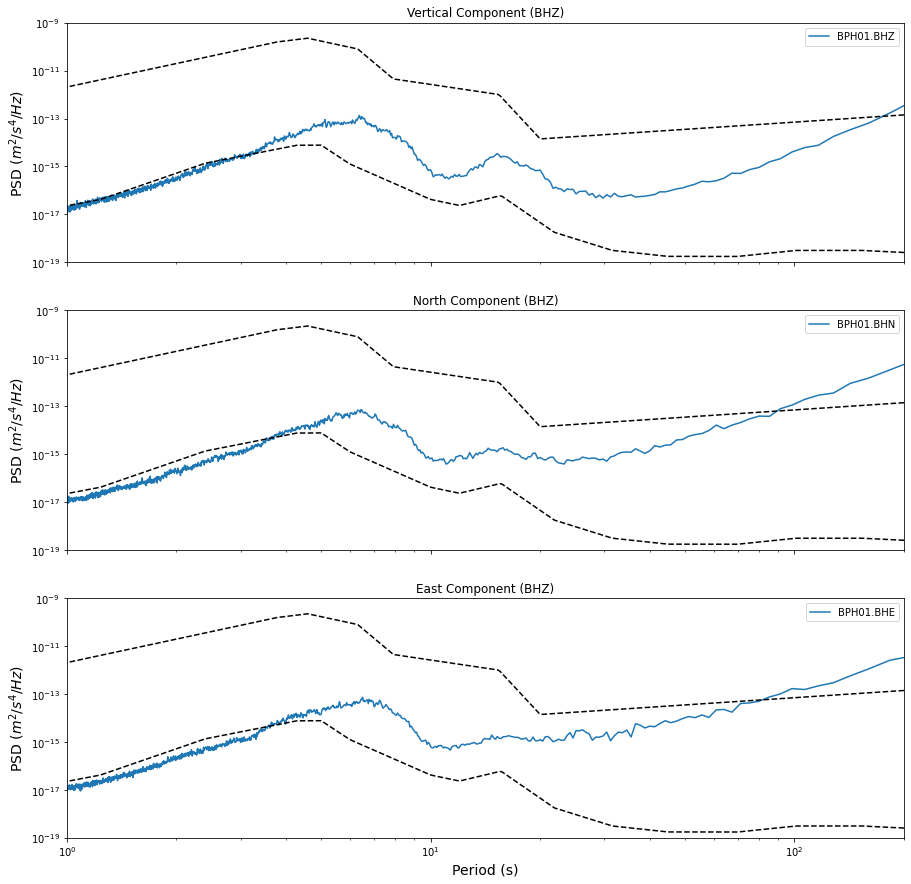

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-29T00:00:00.000000Z - 2019-08-29T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-29T00:00:00.000000Z - 2019-08-29T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-29T00:00:00.000000Z - 2019-08-29T23:59:59.950000Z | 20.0 Hz, 1728000 samples


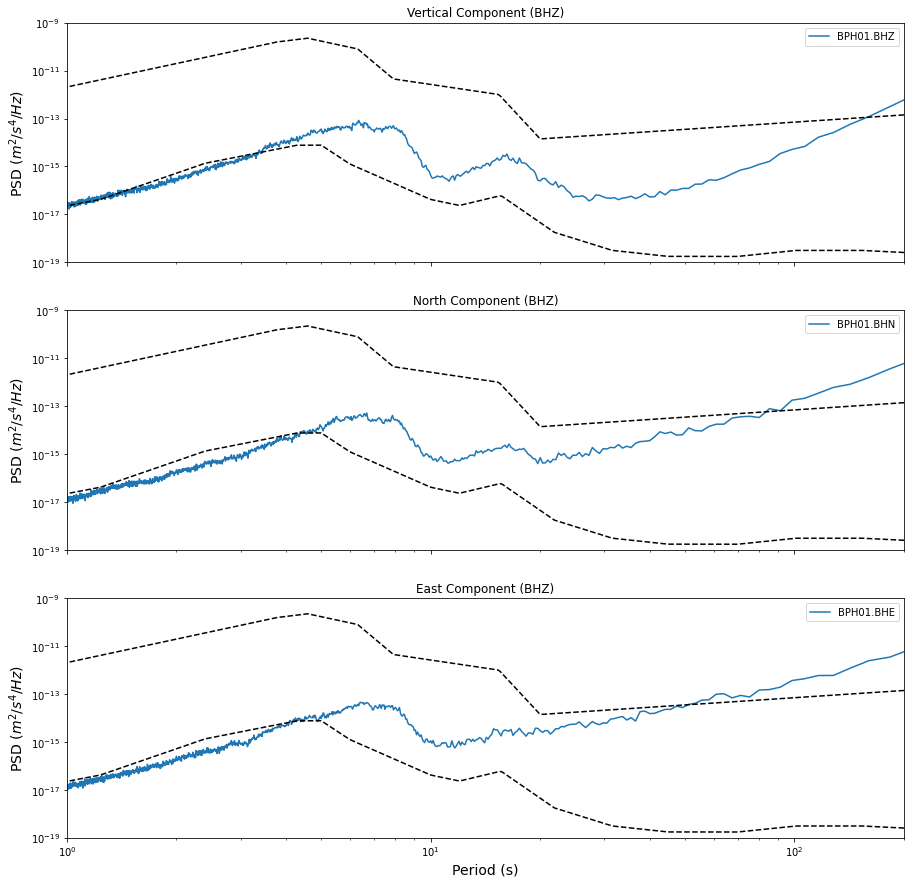

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-30T00:00:00.000000Z - 2019-08-30T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-30T00:00:00.000000Z - 2019-08-30T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-30T00:00:00.000000Z - 2019-08-30T23:59:59.950000Z | 20.0 Hz, 1728000 samples


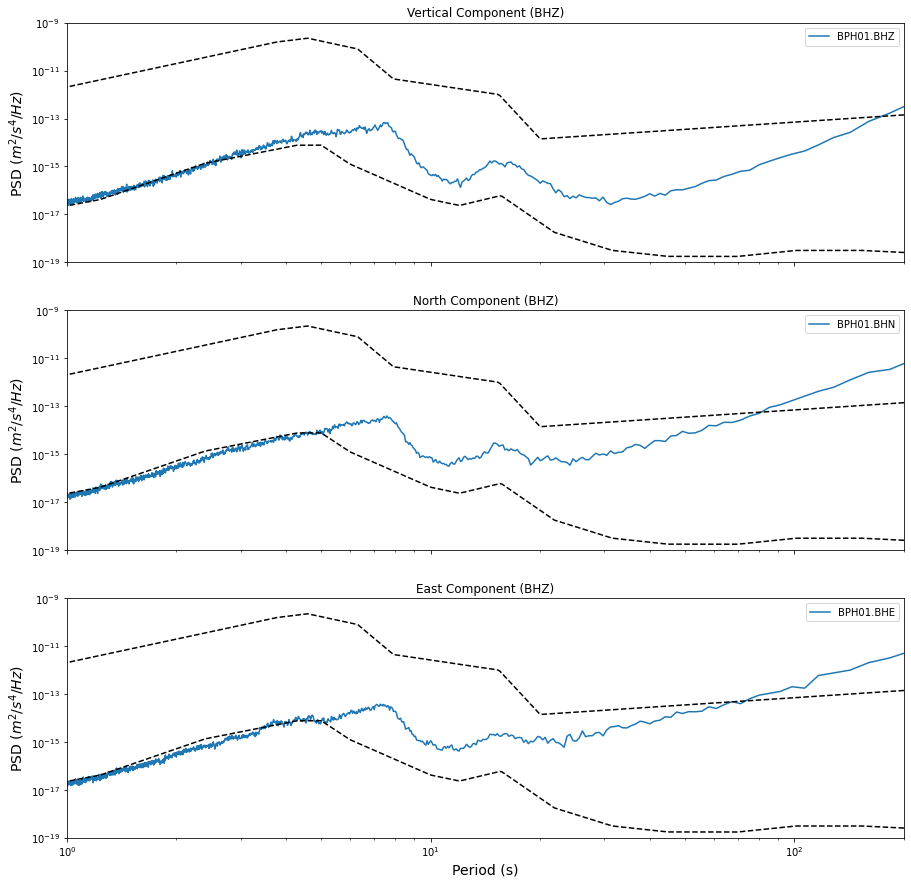

loading PY.BPH01..BHZ...
 -> removing response...
loading PY.BPH01..BHN...
 -> removing response...
loading PY.BPH01..BHE...
 -> removing response...

completed loading
 -> trimming stream...
1 Trace(s) in Stream:
PY.BPH01..BHE | 2019-08-31T00:00:00.000000Z - 2019-08-31T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHN | 2019-08-31T00:00:00.000000Z - 2019-08-31T23:59:59.950000Z | 20.0 Hz, 1728000 samples
1 Trace(s) in Stream:
PY.BPH01..BHZ | 2019-08-31T00:00:00.000000Z - 2019-08-31T23:59:59.950000Z | 20.0 Hz, 1728000 samples


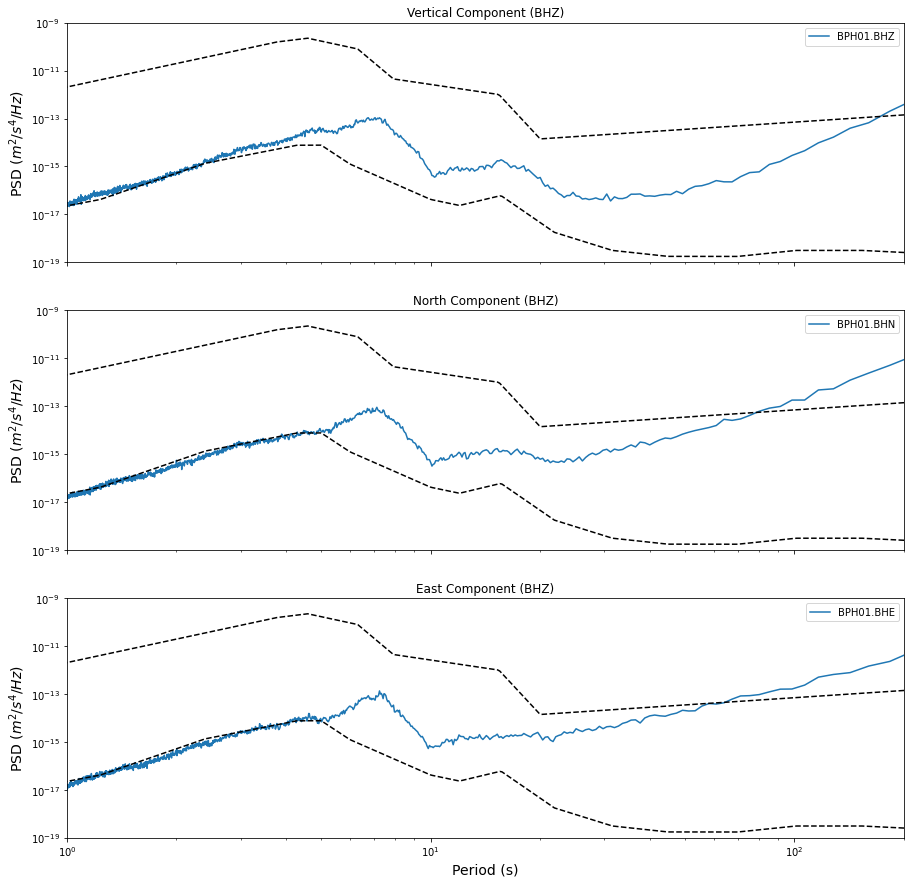

In [7]:
from pandas import date_range

for date in date_range(start="2019-08-01", end="2019-08-31"):  
    
    date_str = str(date).split(' ')[0].replace('-','')
    
    config['seeds'] = [f'PY.BPH01..BHZ', f'PY.BPH01..BHN', f'PY.BPH01..BHE']
    
    config['tbeg'] = obs.UTCDateTime(date)
    config['tend'] = obs.UTCDateTime(date) + 86400
    
    config['stations'] = np.unique(np.array([i.split(".")[1] for i in config['seeds']]))
    config['channels'] = np.unique(np.array([i.split(".")[3] for i in config['seeds']]))
    
    st = __getStream(config)

    st = st.resample(20)
    
    psds, frequencies, station_names = [], [], []

    for cha in config['channels']:
        for sta in config['stations']:
            
            print(st.select(id=f"*.{sta}.*.{cha}"))
            
            station_names.append(f"{sta}.{cha}")

            ff, psd = __calculate_spectra(st.select(id=f"*.{sta}.*.{cha}"), config, mode=None)

            psd_median = __get_median_psd(psd)

            psds.append(psd_median)
            frequencies.append(ff)
            
    fig = __makeplot_PSD_components(psds, frequencies, config)
    fig.savefig(config['outdir_figs']+sta+date_str+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)
    
    del st